# Rice Disease Detection

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Reshape, Dropout, MultiHeadAttention
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sb
from sklearn.metrics import confusion_matrix

## Allocate memory and environment to GPU

In [2]:
phy_devices = tf.config.experimental.list_physical_devices('GPU')
print(phy_devices)
if phy_devices:
    print("Memory allocation and computations pushed to GPU env")
    tf.config.experimental.set_memory_growth(phy_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory allocation and computations pushed to GPU env


## Data extraction and augmentation

In [3]:
#dataset path
dataset_dir = 'D:/Andrei/Andrei/Prog Applications/datasets'
dataset_name = '/_Preprocessed_Rice diseases exclusively_with_valid'
dataset_dir = dataset_dir + dataset_name

#image details
size = (224, 224)
img_color_mode = 'rgb'
img_type = '.jpg'

In [4]:
class_names=['blast','blight','tungro']

In [5]:
N=[]
for i in range(len(class_names)):
    N+=[i]
    
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names)) 

def mapper(value):
    return reverse_mapping[value]

## Data Retrieval Functions

In [6]:
def get_trainXY_and_validXY(train_path, valid_path, size=(224,224), batch_size=1):
    train_batch = tf.keras.utils.image_dataset_from_directory(
        directory=train_path, 
        image_size=size,
        labels='inferred',
        label_mode='categorical',
        shuffle=True,
        batch_size=batch_size,
        seed = 9
    )
    
    valid_batch = tf.keras.utils.image_dataset_from_directory(
        directory=valid_path, 
        image_size=size, 
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed = 9
    )
    
    X = []
    Y = []
    for images, labels in train_batch.take(-1):
        X.append(images.numpy()[0,:,:,:])
        Y.append(labels.numpy()[0])
    vX = []
    vY = []
    for images, labels in valid_batch.take(-1):
        vX.append(images.numpy()[0,:,:,:])
        vY.append(labels.numpy()[0])
        
    return np.array(X), np.array(Y), np.array(vX), np.array(vY)


def get_testXYbatch(test_path, size=(224,224), batch_size=1):
    test_batch = tf.keras.utils.image_dataset_from_directory(
        directory=test_path, 
        image_size=size, 
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
    )

    X = []
    Y = []
    for images, labels in test_batch.take(-1):
        X.append(images.numpy()[0,:,:,:])
        Y.append(labels.numpy()[0])
    return np.array(X), np.array(Y), test_batch

In [7]:
trainx, trainy, validx, validy = get_trainXY_and_validXY(f'{dataset_dir}/training', f'{dataset_dir}/validation')
testx, testy, testbatch = get_testXYbatch(f'{dataset_dir}/testing')

Found 1200 files belonging to 3 classes.
Found 48 files belonging to 3 classes.
Found 48 files belonging to 3 classes.


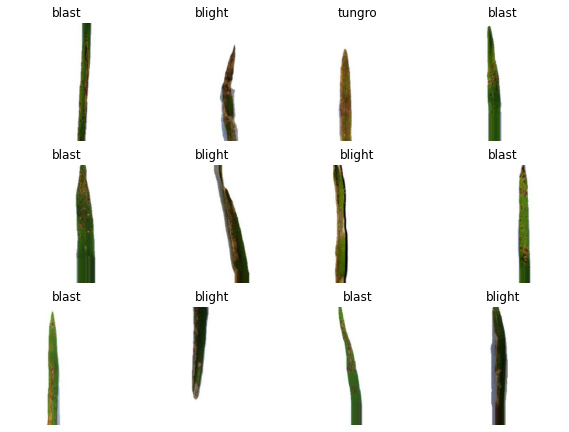

In [8]:
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    image = trainx[i] 
    plt.imshow(image.astype("uint8"))
    plt.title(class_names[np.argmax(trainy[i], axis=-1)])
    plt.axis("off")

In [9]:
# normalize/standardize dataset
trainx /= 255
validx /= 255
testx /= 255

In [10]:
print(f"Training data shape: {trainx.shape}")
print(f"Validation data shape: {validx.shape}")
print(f"Testing data shape: {testx.shape}")
print(f"Classifications: {len(class_names)}, {class_names}")

Training data shape: (1200, 224, 224, 3)
Validation data shape: (48, 224, 224, 3)
Testing data shape: (48, 224, 224, 3)
Classifications: 3, ['blast', 'blight', 'tungro']


### Custom Layers

In [11]:
def ReshapeLayer(x):
    shape = x.shape
    reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    return reshape

def BiLSTMLayer(x, neurons=128):
    # Tanh Activation provides access of the LSTM to the cuDNN which provides faster computation
    return Bidirectional(LSTM(neurons, activation='tanh', recurrent_dropout=0))(x)

def AttentionLayer(x, heads = 1, dim = 1, training = False):
    return MultiHeadAttention(num_heads=heads, key_dim=dim)(x, x, training=training)

# Models

In [130]:
def DenseBilstm(attention=False):
    cnn = tf.keras.applications.DenseNet201(
        input_shape=(size[0],size[1],3),
        include_top=False,
        weights='imagenet'
    )
    cnn.trainable = False
    
    #Model Sequence
    images = cnn.input
    x = cnn.output
    if attention:
        x = AttentionLayer(x, heads = 4, dim = 4, training = True)
    x = ReshapeLayer(x)
    x = BiLSTMLayer(x, 128)
    pred = Dense(3, activation='softmax')(x)
        
    model = tf.keras.Model(inputs=images, outputs=pred)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [131]:
def MoBilstm(attention=False):
    cnn = tf.keras.applications.MobileNet(
        input_shape=(size[0],size[1],3),
        include_top=False,
        weights='imagenet'
    )
    cnn.trainable = False
    
    #Model Sequence
    images = cnn.input
    x = cnn.output
    if attention:
        x = AttentionLayer(x, heads = 2, dim = 2, training = True)
    x = ReshapeLayer(x)
    x = BiLSTMLayer(x, 128)
    pred = Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=images, outputs=pred)
    model.compile(
          optimizer=tf.keras.optimizers.Adam(0.001),
          loss='categorical_crossentropy',
          metrics=['accuracy']
    )
    return model

# Training

In [132]:
model_label = 'mnet_bilstm_att_sample1'

# set early stopping criteria
pat = 5 # this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1, baseline=None)

# to save the history of models
csv_logger = CSVLogger(f'logs/{model_label}.log', separator=",", append=True)

# define the model checkpoint callback -> this will keep on saving the model as a physical file
def ModelCheckPointCB(model_label = 'mnet_bilstm_sample1', save_best_only=True):
    return ModelCheckpoint(
        f'model_checkpoints/{model_label}.h5', 
        verbose=1, save_best_only=save_best_only
    )

In [133]:
model1 = DenseBilstm(attention = True)
model1.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_22 (ZeroPadding2 (None, 230, 230, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_22[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

Total params: 32,342,259
Trainable params: 14,020,275
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [ ]:
# model 1, DenseBiLSTM_noAttention
model_label = "DenseBiLSTM_withAttention"
history1 = model1.fit(
        x = ImageDataGenerator().flow(trainx,trainy,batch_size=16),
        validation_data = ImageDataGenerator().flow(validx, validy, batch_size=16),
        batch_size=32,
        epochs=50,
        callbacks=[early_stopping, ModelCheckPointCB(model_label), csv_logger],
        verbose=1,            
    )

Epoch 1/50
75/75 [==============================] - 37s 233ms/step - loss: 0.4988 - accuracy: 0.7800 - val_loss: 0.4015 - val_accuracy: 0.8125

Epoch 00001: val_loss improved from inf to 0.40153, saving model to model_checkpoints\DenseBiLSTM_withAttention.h5
Epoch 2/50
34/75 [============>.................] - ETA: 6s - loss: 0.1029 - accuracy: 0.9669

In [115]:
# model 2, MoBiLSTM_noAttention
model2 = MoBilstm(attention = True)
model2.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
___________________________________________________________________________________________

In [33]:
model_label2 = "MoBiLSTM_withAttention"
history2 = model2.fit(
        x = ImageDataGenerator().flow(trainx,trainy,batch_size=16),
        validation_data = ImageDataGenerator().flow(validx, validy, batch_size=16),
        batch_size=32,
        epochs=50,
        callbacks=[early_stopping, ModelCheckPointCB(model_label2), csv_logger],
        verbose=1,            
    )

Epoch 1/50
75/75 [==============================] - 13s 96ms/step - loss: 0.8768 - accuracy: 0.5925 - val_loss: 0.8894 - val_accuracy: 0.7083

Epoch 00001: val_loss improved from inf to 0.88943, saving model to model_checkpoints\MoBiLSTM_withAttention.h5
Epoch 2/50
75/75 [==============================] - 6s 75ms/step - loss: 0.2770 - accuracy: 0.9033 - val_loss: 0.4844 - val_accuracy: 0.8333

Epoch 00002: val_loss improved from 0.88943 to 0.48441, saving model to model_checkpoints\MoBiLSTM_withAttention.h5
Epoch 3/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0979 - accuracy: 0.9683 - val_loss: 1.0697 - val_accuracy: 0.7292

Epoch 00003: val_loss did not improve from 0.48441
Epoch 4/50
75/75 [==============================] - 5s 69ms/step - loss: 0.0756 - accuracy: 0.9750 - val_loss: 0.4718 - val_accuracy: 0.8333

Epoch 00004: val_loss improved from 0.48441 to 0.47180, saving model to model_checkpoints\MoBiLSTM_withAttention.h5
Epoch 5/50
75/75 [==================

# Data Presentation

### DenseBiLSTM

In [ ]:
get_acc = history1.history['accuracy']
value_acc = history1.history['val_accuracy']
get_loss = history1.history['loss']
validation_loss = history1.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title(f'{model_label} Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title(f'{model_label} Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
y_pred=model1.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{model_label} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [ ]:
print(classification_report(ground,pred))

In [ ]:
model1.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

### MoBiLSTM

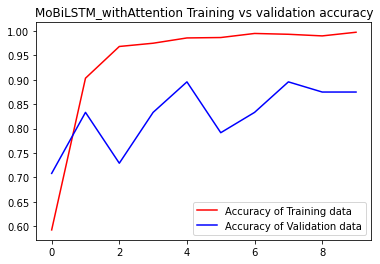

<Figure size 432x288 with 0 Axes>

In [37]:
get_acc = history2.history['accuracy']
value_acc = history2.history['val_accuracy']
get_loss = history2.history['loss']
validation_loss = history2.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title(f'{model_label2} Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

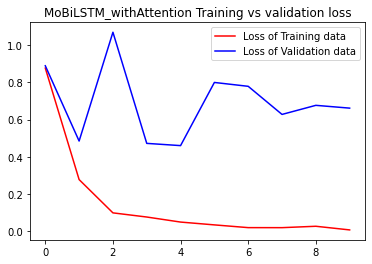

<Figure size 432x288 with 0 Axes>

In [38]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title(f'{model_label2} Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

[Text(0, 0.5, 'blast'), Text(0, 1.5, 'blight'), Text(0, 2.5, 'tungro')]

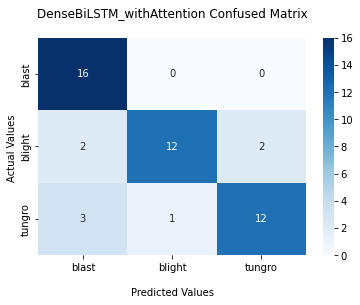

In [39]:
y_pred=model2.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{model_label} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [40]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        16
           1       0.92      0.75      0.83        16
           2       0.86      0.75      0.80        16

    accuracy                           0.83        48
   macro avg       0.85      0.83      0.83        48
weighted avg       0.85      0.83      0.83        48



In [41]:
model2.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

2/2 [==============================] - 0s 48ms/step - loss: 0.9166 - accuracy: 0.8333


[0.9166309237480164, 0.8333333134651184]

In [ ]:
saved_model_file_path = 'model_checkpoints/'
saved_model_name = "DenseBiLSTM_withAttention"
#saved_model_name = "MoBiLSTM_withAttention"
saved_model = tf.keras.models.load_model(saved_model_file_path + saved_model_name + '.h5')
saved_model.summary()

y_pred=saved_model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

In [ ]:
conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{saved_model_name} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [ ]:
print(classification_report(ground,pred))

In [ ]:
saved_model.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

In [ ]:
print(saved_model.optimizer.get_config())